In [16]:
# loading necessary libraries
import json
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from src.PostAnalysis import BinSamples
from src.PostProcessing import HuffmanEncoding

# fixing global variables
plt.style.use("bmh")
# set the golbal figure size
rcParams["figure.figsize"] = (20, 10)
# set the number of photos, modes, free parametres, 
# version and the number of shots
n, m, n_param, v, N = 4, 4, 5, 0, 1000000
# set the data path
data_path = "data/n{}_m{}_nparam{}_v{}".format(n, m, n_param, v)

# function definitions
def vocab_occurrenc(keyword: str):
    with open("{}/{}_strs_N{}.json".format(data_path, keyword, N)) as f:
        algo_strs = json.load(f)
    algo_strs = list(filter(lambda x: x != '', algo_strs))
    occurrences = Counter(algo_strs)
    occurrences = [(key, val) for key, val in occurrences.items()]
    occurrences.sort(key=lambda x: x[1], reverse=True)
    occurrences = {el[0]: el[1] for el in occurrences}
    plt.bar(list(occurrences.keys()), list(occurrences.values()))
    plt.xticks(rotation=90)
    plt.show()
    return algo_strs

def stat_binstream_length(bin_str_list: list, start: int, end: int, stride: int):
    samp = BinSamples(bin_str_list)
    trunc_indices = range(start, end, stride)
    ratio = samp.truncated_ensemble(trunc_indices=trunc_indices)
    return ratio

def zero_one_ratio(ratio_stat: dict, vonneumann: bool):
    zero_one_diff = [ratio_stat[key]["ratio"]["0"]/ratio_stat[key]["ratio"]["1"] for key in ratio_stat.keys()]
    plt.plot(list(ratio_stat.keys()), zero_one_diff)
    plt.ylabel("ratio of the number of 0's to the number of 1's\nin a continuous binary stream")
    if vonneumann:
        plt.xlabel("#Shots/2")
    else:
        plt.xlabel("#Shots")
    plt.show()

## Boson Sampling using _fock_ backend
### Architecture
The architecture of the Boson Sampler (BS) used throughout this study is as follows

<p align="center">
<img src="figs/architecture.png"
     alt="Boson Sampler Architecture"/>
</p>

It has four modes and four photons enter from the left side (shown in red circles). The Beam splitters are shown in yellow rectangles and have their transmittivity $\theta$ set is to $\pi/4$ and phase angle $\phi$ to $0$. The photodetectors are shown as blue semi-circles on the right hand side.

The exact solution of the probabilities of the fock states for the BS shown above is depicted in the following bar plot.

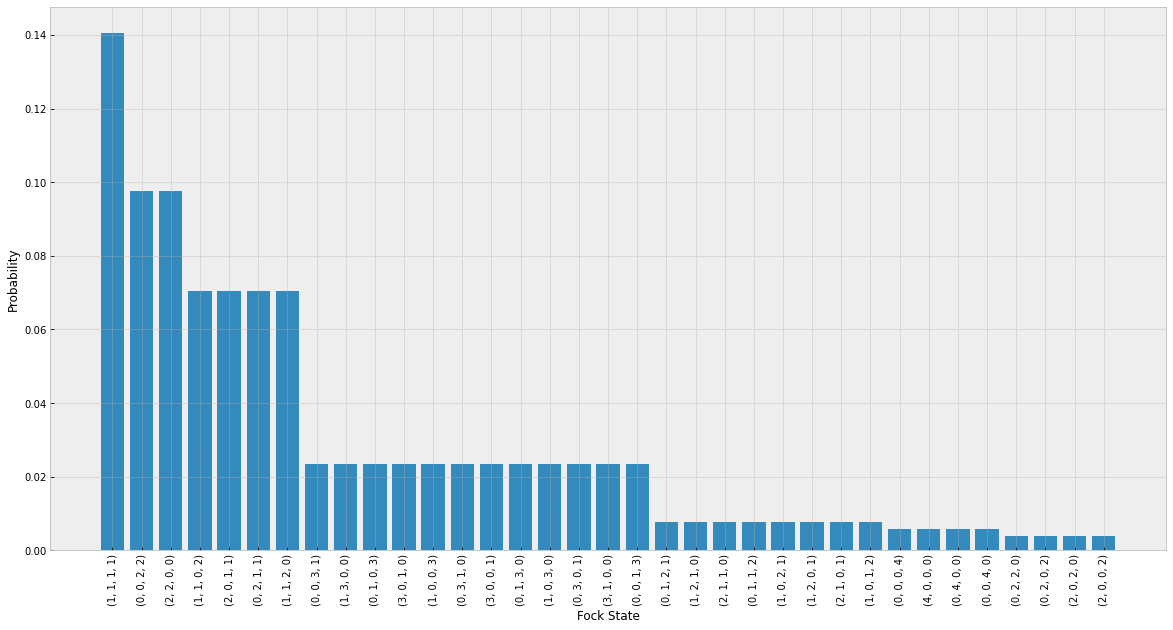

In [2]:
with open("{}/exact_result.json".format(data_path), "r") as f:
    fock_dist = json.load(f)

plt.bar(list(fock_dist.keys()), list(fock_dist.values()))
plt.ylabel("Probability")
plt.xlabel("Fock State")
plt.xticks(rotation=90);

### Von Neumann Post-Processing
The von Neumann debiasing discussed in [[1]](https://arxiv.org/abs/2206.02292) takes two sampled fock states and convert them to two binary states e.g. take two fock states _(0, 2, 0, 2)_ and _(0, 0, 0, 4)_, their binary representations are _(0, 1, 0, 1)_ and _(0, 0, 0, 1)_ respectively. Then elementwise, apply the following protocol 

bit 1 | bit 2 | output
----- | ----- | ------
  0   |   0   |   *
  0   |   1   |   0
  1   |   0   |   1
  1   |   1   |   *

Where _*_ stands on discarded. Hence for the two fock states above, the extracted binary string yields _\*1\*\*_ which simplifies to _1_. After measuring the BS $10^4$ and recording the binary strings after the von Neumann debiasing the following histogram is yielded.

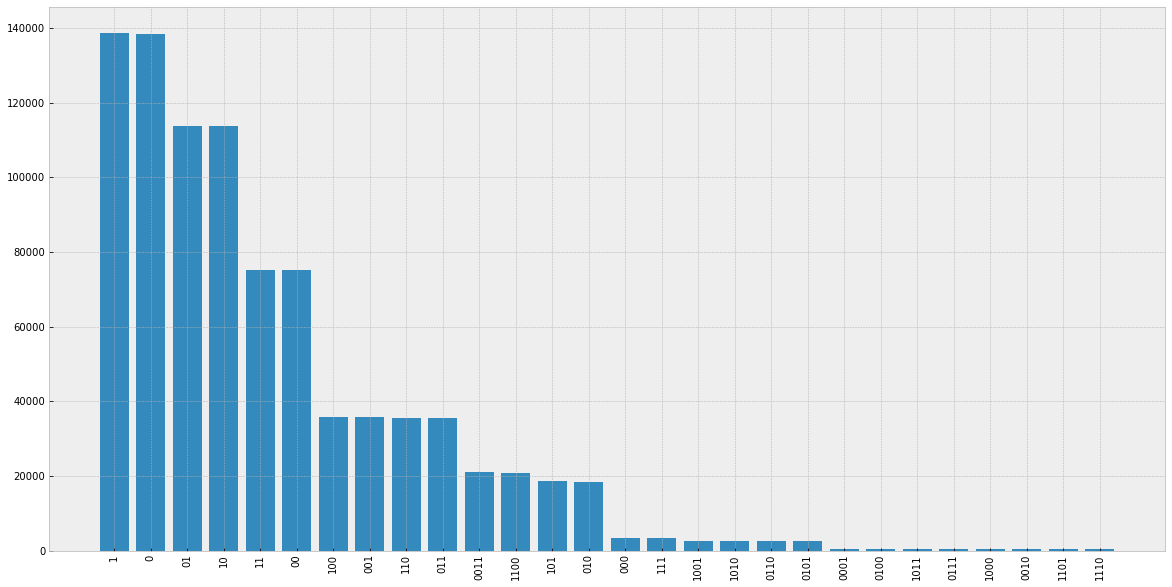

In [8]:
vonneumann_strs = vocab_occurrenc("vonneumann")

A contineous stream of these binary strings which is yielded by concatenating them consequtively, is supposed to produce an unbiased appearance of the bits _0_ and _1_ i.e. the number of _0_'s is as much as the number of _1_'s in the string when the length of the stream tends to infinity.

In [12]:
neumann_ratio = stat_binstream_length(vonneumann_strs, 1000, len(vonneumann_strs), 1000)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-2)]: Done 132 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-2)]: Done 258 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-2)]: Done 420 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 618 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 852 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 898 out of 898 | elapsed:  2.3min finished


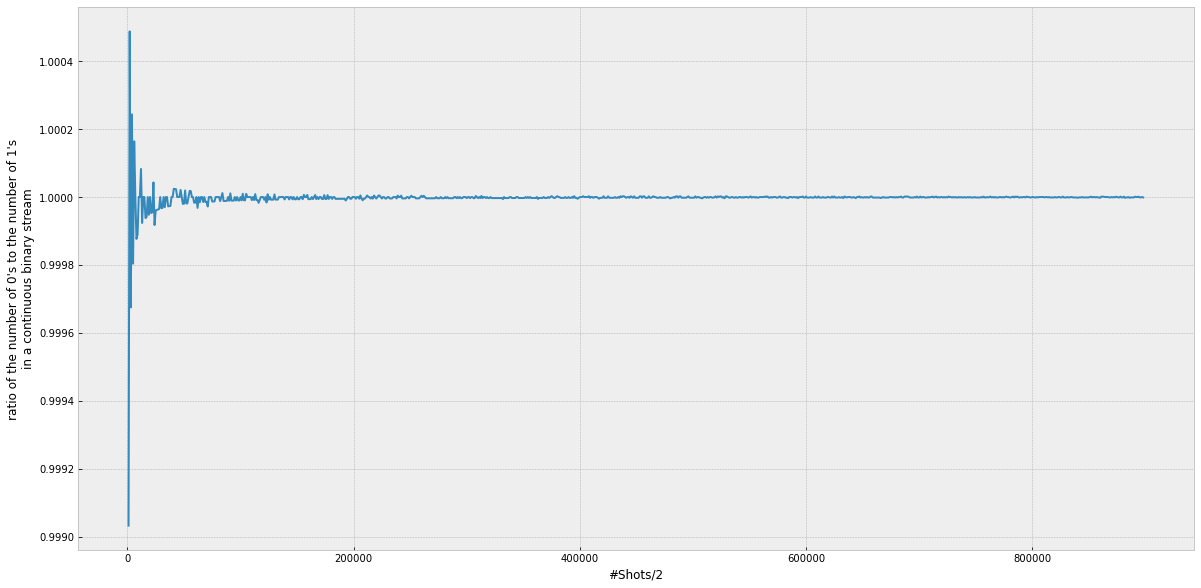

In [17]:
zero_one_ratio(neumann_ratio, True)

As demonstrated in the figure above, it is easy to verify that the number of _0_'s in a continuous stream of binary stream as as high as the number of _1_'s within the same stream.

In [28]:
cat data/n4_m4_nparam5_v0/nist_vonneumann.txt

------------------------------------------------------------------------------
RESULTS FOR THE UNIFORMITY OF P-VALUES AND THE PROPORTION OF PASSING SEQUENCES
------------------------------------------------------------------------------
   generator is <../boson-sampling/data/n4_m4_nparam5_v0/vonneumann.bin>
------------------------------------------------------------------------------
 C1  C2  C3  C4  C5  C6  C7  C8  C9 C10  P-VALUE  PROPORTION  STATISTICAL TEST
------------------------------------------------------------------------------
  0   0   0   0   0   0   0   0   0 110  0.000000 *  110/110     Frequency
  0   0   0   0   0   0   0   0   0 110  0.000000 *  110/110     BlockFrequency
  0   0   0   0   0   0   0   0   0 110  0.000000 *  110/110     CumulativeSums
  0   0   0   0   0   0   0   0   0 110  0.000000 *  110/110     CumulativeSums
110   0   0   0   0   0   0   0   0   0  0.000000 *    0/110  *  Runs
110   0   0   0   0   0   0   0   0   0  0.000000 *    0/110  *  Lon

### Huffman Encoding Post-Processing
the von Neumann post-processing requires two input states (fock states). This consequently leads to a lower bit-rate. Moreover it requires an extra bit-wise operation to extract the entropy out of the non-uniform fock states. Besides, it happens quite often that we produce the empty string since the two fock states are the same. To overcome these disadvantages, a new encoding scheme is suggested here called Huffman encoding. In this encoding scheme the fock states are assigned to a binary string. The higher the probability of the appearance of a given fock state is, the shorter the binary string encoding is. This leads to an efficient encoding (the most efficient encoding actually) of the fock states into binary representation. For instance for the fock states illustrated above we have the following encoding

In [18]:
with open("data/n4_m4_nparam5_v0/exact_result.json", "r") as f:
    fock_probs = json.load(f)
huff_enc = HuffmanEncoding(fock_probs)
huff_enc.huffman_encoding()
print({key: val[0] for key, val in huff_enc.encoding.items()})

{'(1, 1, 1, 1)': '101', '(0, 0, 2, 2)': '001', '(2, 2, 0, 0)': '010', '(1, 1, 0, 2)': '1100', '(2, 0, 1, 1)': '1101', '(0, 2, 1, 1)': '1000', '(1, 1, 2, 0)': '1001', '(0, 0, 3, 1)': '01101', '(1, 3, 0, 0)': '01100', '(0, 1, 0, 3)': '00010', '(3, 0, 1, 0)': '00011', '(1, 0, 0, 3)': '00001', '(0, 3, 1, 0)': '111111', '(3, 0, 0, 1)': '00000', '(0, 1, 3, 0)': '111110', '(1, 0, 3, 0)': '111100', '(0, 3, 0, 1)': '111011', '(3, 1, 0, 0)': '111010', '(0, 0, 1, 3)': '111001', '(0, 1, 2, 1)': '1110000', '(1, 2, 1, 0)': '0111111', '(2, 1, 1, 0)': '0111110', '(0, 1, 1, 2)': '0111101', '(1, 0, 2, 1)': '0111100', '(1, 2, 0, 1)': '0111011', '(2, 1, 0, 1)': '0111010', '(1, 0, 1, 2)': '0111000', '(0, 0, 0, 4)': '11110111', '(4, 0, 0, 0)': '11110110', '(0, 4, 0, 0)': '11110101', '(0, 0, 4, 0)': '11110100', '(0, 2, 2, 0)': '11100011', '(0, 2, 0, 2)': '01110011', '(2, 0, 2, 0)': '11100010', '(2, 0, 0, 2)': '01110010'}


It is obvious if we simply convert a sequence of fock states and convert them to their binary representation, the final stream of the binary string is biased. To elaborate this and justify this further, take the most probable fock state which is (1, 1, 1, 1). This fock state is encoded by _101_ binary code which is already biased as 2/3 in favour of the bit _1_. Eventually, sampling more and more of this fock state produces an enormous bias of generating more _1_ bit. To resolve this issue, we can flip the bits every time we use one specific codeword. For instance, the first time we use _101_ for encoding the fock state (1, 1, 1, 1), for the next time when we sample this very fock state we flip the bits and use _010_. This way, we ensure that we remove the bias in the long run.

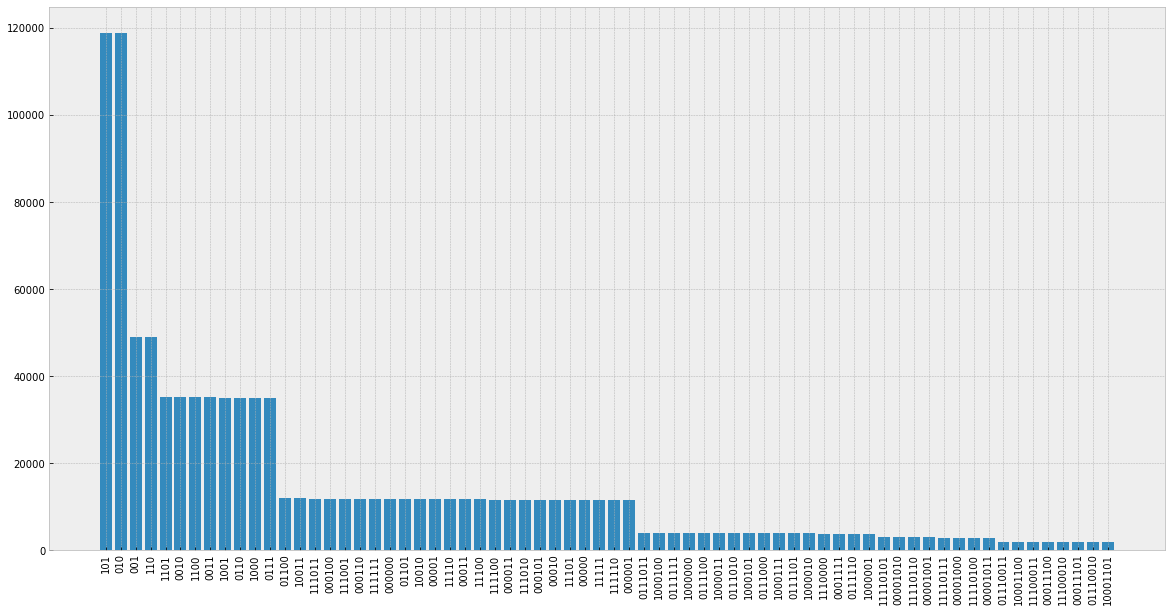

In [19]:
huffman_strs = vocab_occurrenc("huffman")

In [20]:
huffman_ratio = stat_binstream_length(huffman_strs, 1000, len(huffman_strs), 1000)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-2)]: Done 132 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-2)]: Done 258 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-2)]: Done 420 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 618 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 852 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done 999 out of 999 | elapsed:  3.5min finished


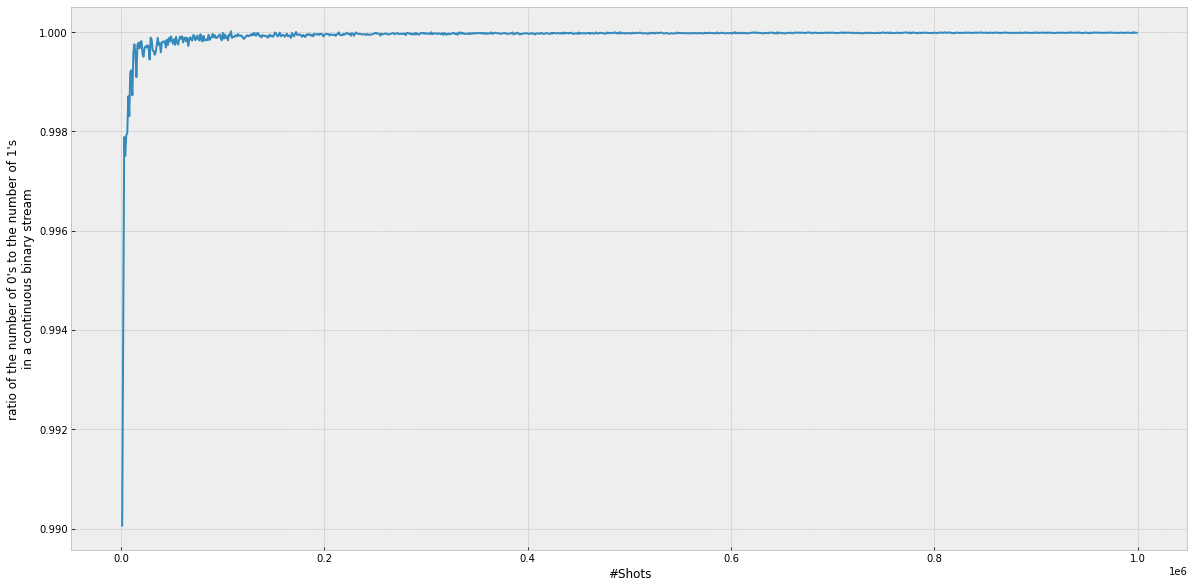

In [22]:
zero_one_ratio(huffman_ratio, False)

It is seen that the ration between the _0_ bits and the _1_ bits converge to unity when the length of the binary stream grows. The pace it which the ration converge to unity here compared to the von Neumann post-processing is indeed slower, yet we are able to achieve a higher bit rate (produce longer stream) as every single sampled fock state contributes to the stream not two.

In [30]:
cat data/n4_m4_nparam5_v0/nist_huffman.txt

------------------------------------------------------------------------------
RESULTS FOR THE UNIFORMITY OF P-VALUES AND THE PROPORTION OF PASSING SEQUENCES
------------------------------------------------------------------------------
   generator is <../boson-sampling/data/n4_m4_nparam5_v0/huffman.bin>
------------------------------------------------------------------------------
 C1  C2  C3  C4  C5  C6  C7  C8  C9 C10  P-VALUE  PROPORTION  STATISTICAL TEST
------------------------------------------------------------------------------
  0   0   0   0   0   0   0   1  35 234  0.000000 *  270/270     Frequency
  0   0   0   0   0   0   0   0   0 270  0.000000 *  270/270     BlockFrequency
  0   0   0   0   0   0   0   0   0 270  0.000000 *  270/270     CumulativeSums
  0   0   0   0   0   0   0   0   0 270  0.000000 *  270/270     CumulativeSums
139  30  25  19  10  14   8   9  12   4  0.000000 *  221/270  *  Runs
 87  44  36  29  16  18  12  14  10   4  0.000000 *  250/270  *  Longes


### Degenerate Fock states, Unitary Haar Matrix and Permutation Symmetry
When the architecture of the Boson Sampler admits certain symmetries, such as the one peresented above, the outcome Fock states of the BS from classes of degenerate Fock states. By looking at the figure that depicts the probabilities of the Fock states, we observe that some of the Fock states have the same outcome probability. The architecture devised above, admits even order permutation in the sense depicted in the figure below

<p align="center">
<img src="figs/permutation.png"
     alt="Permutation Symmetry"/>
</p>


The group elements are generated by swapping the first two modes and then simultaneously swapping the second two modes. The next element is achieved by swapping the first two modes by the second two modes. This generates proceduce generates all the group elements of the degenerate Fock states. For the BS architecture given above we have the following group partitions

$$
G_1 = \{(0, 2, 1, 1), (2, 0, 1, 1), (1, 1, 2, 0), (1, 1, 0, 2)\}\\
G_2 = \{(0, 0, 3, 1), (0, 0, 1, 3), (1, 3, 0, 0), (3, 1, 0, 0)\}\\
G_3 = \{(0, 1, 0, 3), (1, 0, 3, 0), (3, 0, 1, 0), (0, 3, 0, 1)\}\\
G_4 = \{(1, 0, 0, 3), (0, 1, 3, 0), (3, 0, 0, 1), (0, 3, 1, 0)\}\\
G_5 = \{(0, 1, 2, 1), (1, 0, 1, 2), (1, 2, 1, 0), (2, 1, 0, 1)\}\\
G_6 = \{(2, 1, 1, 0), (1, 2, 0, 1), (0, 1, 1, 2), (1, 0, 2, 1)\}\\
G_7 = \{(0, 0, 0, 4), (0, 0, 4, 0), (4, 0, 0, 0), (0, 4, 0, 0)\}\\
G_8 = \{(0, 2, 2, 0), (2, 0, 0, 2), (0, 2, 0, 2), (2, 0, 2, 0)\}\\
G_9 = \{(1, 1, 1, 1)\}
$$

The order of $G_i$'s is four, except for $G_9$ which is a singleton set and its element remains invariant under permutation. Within each group $G_i$, since the states are degenerate, we can assign cyclicly the digit _0_ and _1_ to the elements within that group e.g. take $G_1$ and define the following map

$$
(0, 2, 1, 1) \rightarrow 0\\ 
(2, 0, 1, 1) \rightarrow 1\\
(1, 1, 2, 0) \rightarrow 0\\
(1, 1, 0, 2) \rightarrow 1
$$

Since each element in $G_1$ is equally probable to be observed, it is guaranteed that the sequence by zeros and ones generated by this scheme yields an unbiased binary stream. Similarily, for all other $G_i$' we establish a similar map except for $G_9$ where the Fock state $(1, 1, 1, 1)$ is mapped to the empty string $\emptyset$.

The result of this protocol is follows

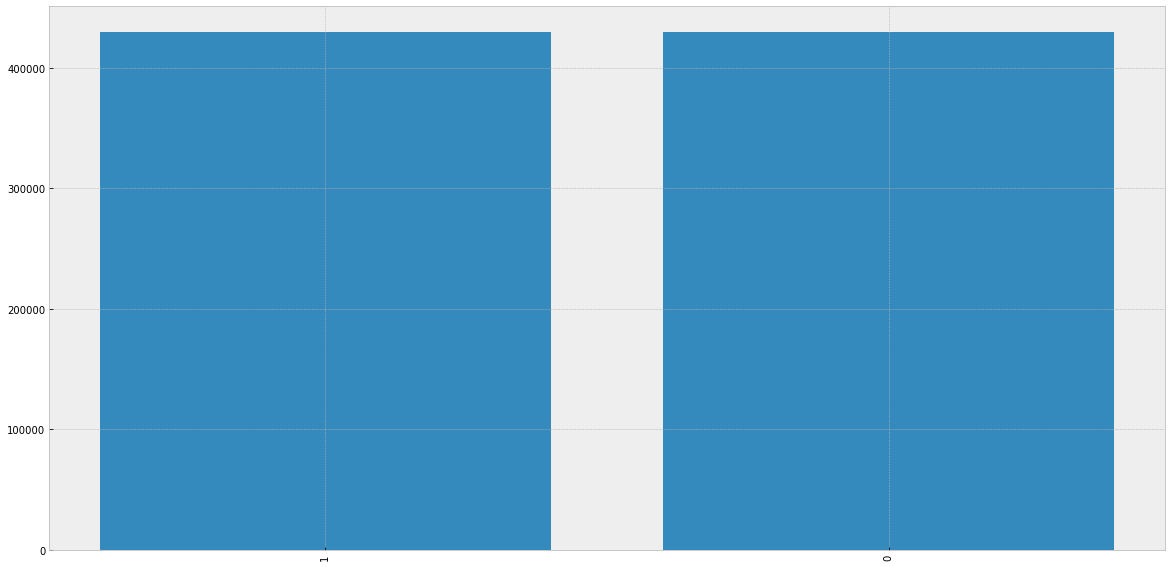

In [23]:
permutation_strs = vocab_occurrenc("permutation")

In [24]:
permutation_ratio = stat_binstream_length(permutation_strs, 1000, len(permutation_strs), 1000)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  54 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 234 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done 486 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done 810 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-2)]: Done 830 out of 859 | elapsed:    8.5s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 859 out of 859 | elapsed:    8.8s finished


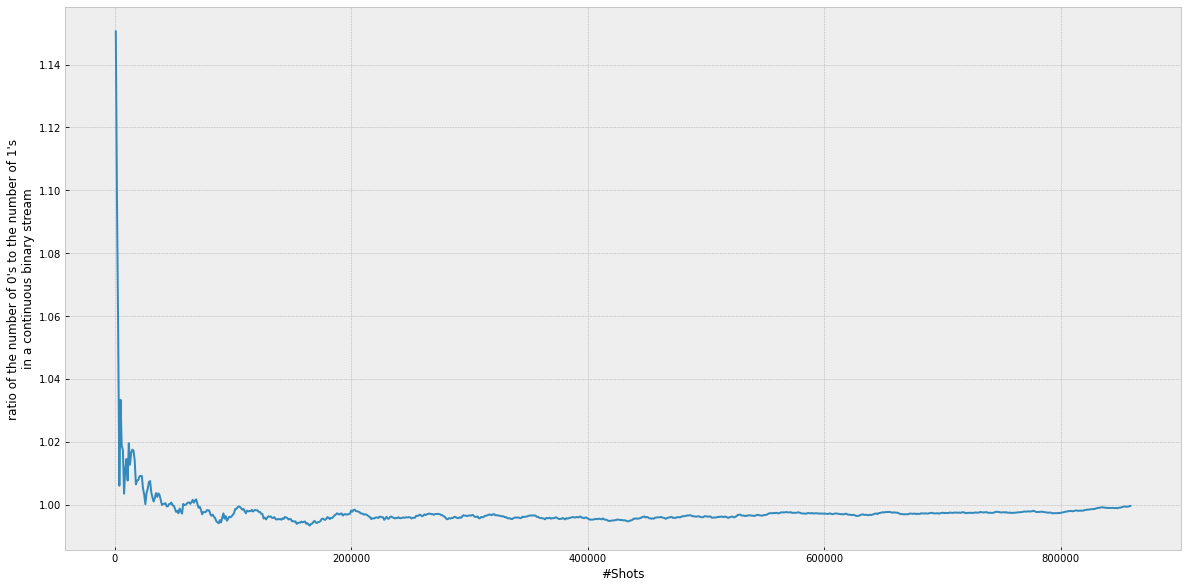

In [25]:
zero_one_ratio(permutation_ratio, False)

In [1]:
cat data/n4_m4_nparam5_v0/nist_permutation.txt

------------------------------------------------------------------------------
RESULTS FOR THE UNIFORMITY OF P-VALUES AND THE PROPORTION OF PASSING SEQUENCES
------------------------------------------------------------------------------
   generator is <../boson-sampling/data/n4_m4_nparam5_v0/permutation.bin>
------------------------------------------------------------------------------
 C1  C2  C3  C4  C5  C6  C7  C8  C9 C10  P-VALUE  PROPORTION  STATISTICAL TEST
------------------------------------------------------------------------------
  4   3   4   6   8   5   3   3  12   4  0.096578     51/52      Frequency
  4   4   7   6   4   8   8   6   2   3  0.534146     51/52      BlockFrequency
  4   4   5   8   5   6   5   8   4   3  0.816537     51/52      CumulativeSums
  4   1   7   7   4   3   9   7   5   5  0.350485     51/52      CumulativeSums
  6   5   1   7   6   5  10   4   5   3  0.319084     52/52      Runs
  4   2   3   5   5   5   8   6   5   9  0.534146     52/52      Lo

### Conclusion
* Compare the three protocols
* Discuss the NIST result
* Plot the p-value of the NIST result for different protocols

16384 - 110
16384 - 270
16384 - 52